# Visualization

This notebook loads, preprocesses, and visualizes raw data from the given dataset, generated from the COMSOL simulations of a single-junction perovskite solar cell. See Zhao Xinhai's PhD thesis for more details on the generation.

Here, we will visualize a few current-voltage (I-V) curves from the dataset. _For interactive visualization, run the code as a Python script._

In [2]:
import numpy as np
import matplotlib.pyplot as plt

Set where to load the data from, provide the path to the folder containing the text files.

In [3]:
DATA_DIR = "../dataset/Data_1k_sets/Data_1k_rng1/"

In [4]:
# LOAD DATA FROM TEXT FILES

# Output: output in the form of current density, A/m^2
Output = np.loadtxt(DATA_DIR + 'iV_m.txt', delimiter=',')
# Input: 31 input parameters
Input = np.loadtxt(DATA_DIR + 'LHS_parameters_m.txt', delimiter=',')

# See MATLAB file for COMSOL sweep that defines the applied voltage range
Va = np.concatenate((np.arange(0, 0.41, 0.1), np.arange(0.425, 1.401, 0.025)))  # applied voltage, V

N = Output.shape[0]  # number of cases

Text(0, 0.5, 'Value')

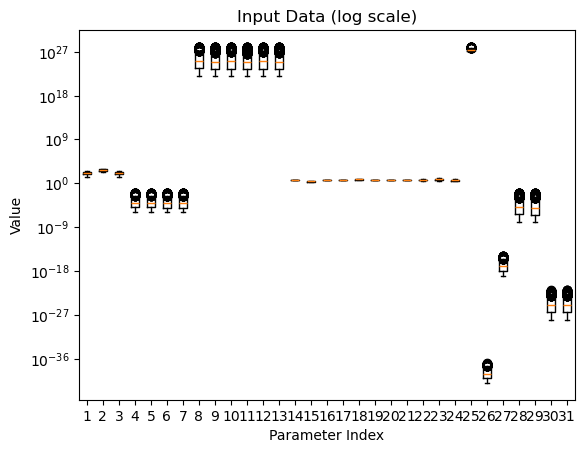

In [9]:
# Input data
plt.figure(4)
plt.boxplot(Input)
plt.yscale('log')
plt.title('Input Data (log scale)')
plt.xlabel('Parameter Index')
plt.ylabel('Value')

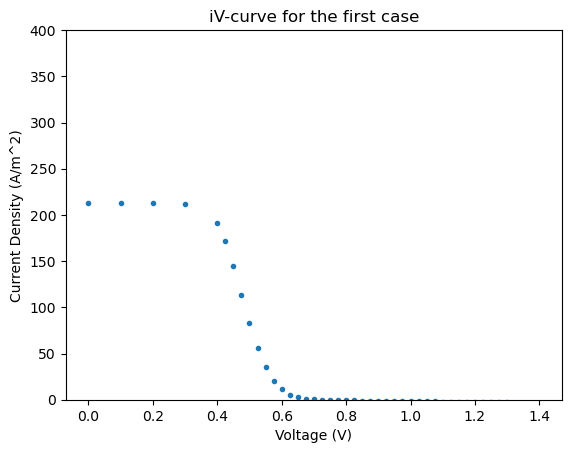

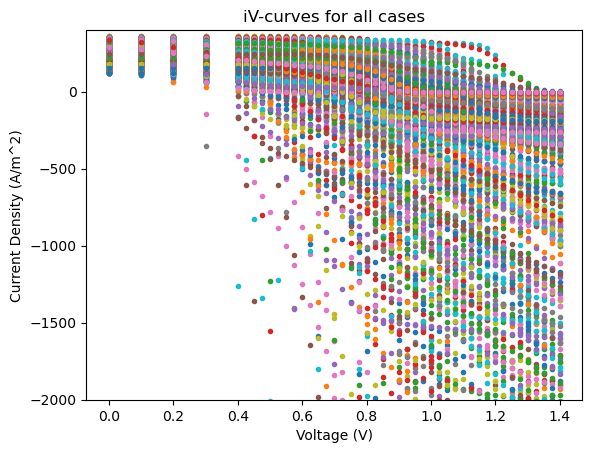

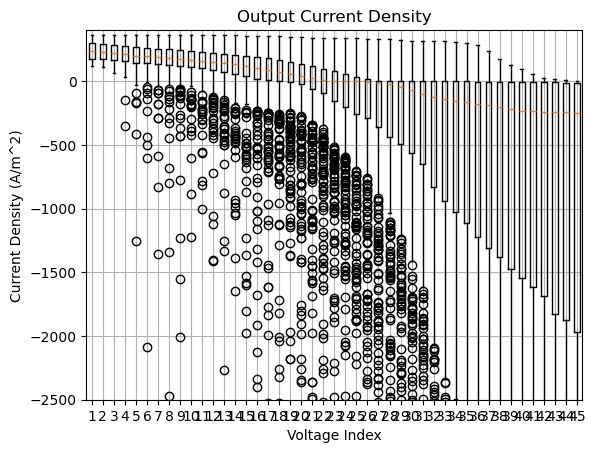

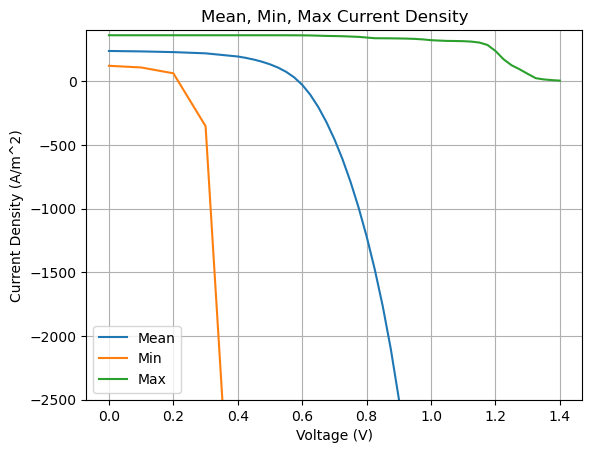

In [10]:
# Some IV curves follows

# iV-curve for the first case
plt.figure(1)
plt.plot(Va, Output[0, :], '.')
plt.ylim([0, 400])
plt.title('iV-curve for the first case')
plt.xlabel('Voltage (V)')
plt.ylabel('Current Density (A/m^2)')

# iV-curves for all cases
plt.figure(2)
for i in range(N):
    plt.plot(Va, Output[i, :], '.')
plt.ylim([-2000, 400])
plt.title('iV-curves for all cases')
plt.xlabel('Voltage (V)')
plt.ylabel('Current Density (A/m^2)')

# Output current density
plt.figure(3)
plt.boxplot(Output)
plt.ylim([-2500, 400])
plt.title('Output Current Density')
plt.xlabel('Voltage Index')
plt.ylabel('Current Density (A/m^2)')
plt.grid(True)

# Mean, max, min current density across all cases
plt.figure(5)
curr_den_mean = np.mean(Output, axis=0)
curr_den_max = np.max(Output, axis=0)
curr_den_min = np.min(Output, axis=0)
plt.plot(Va, curr_den_mean, label='Mean')
plt.plot(Va, curr_den_min, label='Min')
plt.plot(Va, curr_den_max, label='Max')
plt.ylim([-2500, 400])
plt.title('Mean, Min, Max Current Density')
plt.xlabel('Voltage (V)')
plt.ylabel('Current Density (A/m^2)')
plt.grid(True)
plt.legend()

plt.show()